In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

class contrastiveThresholdMaskLoss(nn.Module):
    """
    This is a loss function that is used to train a siamese network
    The loss function is a combination of a threshold and a margin
    
    It does a loss function on pixel basis so the label is depended on the pixel
    so we focus directly on if the featuremap overlays the ground truth tumor
    """
    def __init__(self,hingethresh=0.0,margin=2.0, dist_flag='l2'):
        super(contrastiveThresholdMaskLoss, self).__init__()
        self.threshold = hingethresh
        self.margin = margin
        self.dist_flag = dist_flag

    def various_distance(self,out_vec_t0,out_vec_t1):

        if self.dist_flag == 'l2': # Euclidean distance
            distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=2)
        if self.dist_flag == 'l1': # Manhattan distance
            distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=1)
        if self.dist_flag == 'cos':# Cosine similarity
            similarity = F.cosine_similarity(out_vec_t0,out_vec_t1)
            distance = 1 - 2 * similarity/np.pi
        return distance
    
    def forward(self,map_t0, map_t1,ground_truth):
        n, c, h, w = map_t0.shape

        # Flatten the spatial dimensions
        out_t0_rz = map_t0.view(n, c, -1).transpose(1, 2)  # Shape: (n, h*w, c)
        out_t1_rz = map_t1.view(n, c, -1).transpose(1, 2)  # Shape: (n, h*w, c)
        print(out_t0_rz.shape)
        ## print mean and standard deviation of this tensor
        print(f"Mean: {out_t0_rz.mean()}, std: {out_t0_rz.std()}")
        print(f"Mean: {out_t1_rz.mean()}, std: {out_t1_rz.std()}")
        # Calculate pairwise distance
        distance = self.various_distance(out_t0_rz, out_t1_rz)  # Shape: (n, h*w), basically distance for each batch
        # Reshape distance to match the ground truth shape
        distance = distance.view(n, h, w)  # Shape: (n, h, w)
        # Ensure ground truth tensor is compatible
        gt_rz = ground_truth.squeeze(1)  # Shape: (n, h, w)
    
        ## Print the min and max of the distance map
        print(f"Distance map min: {distance.min()}, max: {distance.max()}")
        # Calculate the contrastive threshold loss
        similar_pair_penalty = torch.clamp(distance - self.threshold, min=0.0) # distance below threshold resolves to 0
        dissimilar_pair_penalty = torch.clamp(self.margin - distance, min=0.0) # distance above margin resolves to 0

        #print(f"Similar pair penalty min: {similar_pair_penalty.min()}, max: {similar_pair_penalty.max()}")
        ## similar part, multiply NON tumor area intensity (by inversion)
        ## with the similar pair penalty (clipped at thresh), so we only get the loss for the NON
        # tumor area
        
        ## vice versa for the dissimilar part
        ## loss += tumor area * distance map clipped at margin
        ## loss += NON tumor area * distance map clipped at threshold
        
        # constractive_thresh_loss = torch.sum(
        #     (1 - gt_rz) * torch.pow(similar_pair_penalty, 2) + gt_rz * torch.pow(dissimilar_pair_penalty, 2)
        # )
        
        #attempting to unsupervise the tumor area
        constractive_thresh_loss = torch.sum(
            (1 - gt_rz) * torch.pow(similar_pair_penalty, 2)
        )
        return constractive_thresh_loss
def various_distance(out_vec_t0,out_vec_t1, dist_flag='l2'):

    if dist_flag == 'l2': # Euclidean distance
        distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=2)
    if dist_flag == 'l1': # Manhattan distance
        distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=1)
    if dist_flag == 'cos':# Cosine similarity
        similarity = F.cosine_similarity(out_vec_t0,out_vec_t1)
        distance = 1 - 2 * similarity/np.pi
    return distance

def return_upsampled_norm_distance_map(output_t0: torch.Tensor,output_t1: torch.Tensor,dist_flag: str,
                                        mode='bilinear'):

    # interp = torch.nn.Upsample(size=[256,256], mode=mode)
    c, h, w = output_t0.data.shape

    # remember the c, h, w -> flatten
    out_t0_rz = torch.transpose(output_t0.view(c, h * w), 1, 0)
    out_t1_rz = torch.transpose(output_t1.view(c, h * w), 1, 0)
    distance = various_distance(out_t0_rz,out_t1_rz,dist_flag=dist_flag)
    print(distance.min(), distance.max())

In [2]:
pre_val = np.load('./../pre_val.npy')
pre_train = np.load('./../pre_train.npy')
post_val = np.load('./../post_val.npy')
post_train = np.load('./../post_train.npy')


In [3]:
loss = contrastiveThresholdMaskLoss()


In [5]:
#loss(torch.tensor(pre_train),torch.tensor(post_train),torch.tensor(pre_train))
loss(torch.tensor(pre_val),torch.tensor(post_val),torch.tensor(pre_val))

torch.Size([16, 1024, 512])
Mean: 0.036876022815704346, std: 0.024357423186302185
Mean: 0.036876022815704346, std: 0.024357425048947334
Distance map min: 2.2490490664495155e-05, max: 3.046232450287789e-05


RuntimeError: The size of tensor a (512) must match the size of tensor b (16) at non-singleton dimension 1

In [32]:
return_upsampled_norm_distance_map(torch.tensor(pre_val[10]),torch.tensor(post_val[10]),'l2')
return_upsampled_norm_distance_map(torch.tensor(pre_train[10]),torch.tensor(post_train[10]),'l1')

tensor(2.2532e-05) tensor(2.3650e-05)
tensor(13.0031) tensor(13.2162)



Training Analysis:
Difference stats - mean: 0.025163, std: 0.025311
Distance stats - mean: 25.826555, min: 24.097527, max: 27.176449


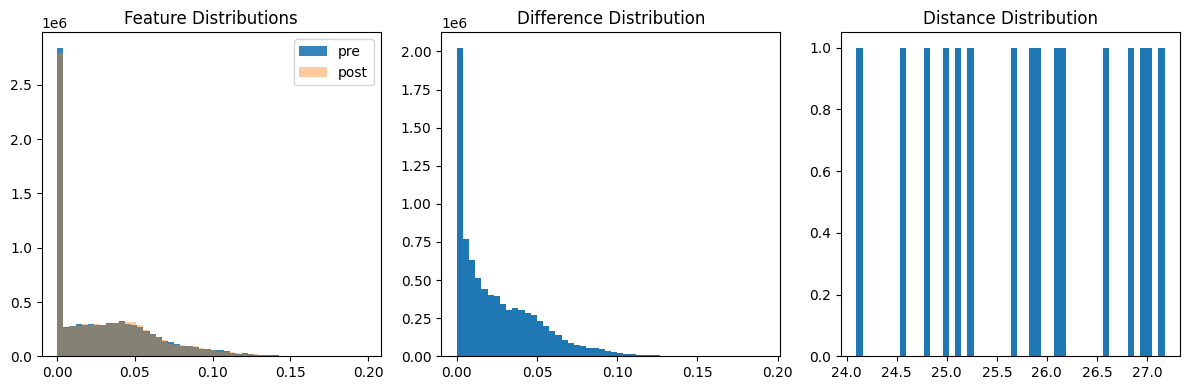


Validation Analysis:
Difference stats - mean: 0.000000, std: 0.000000
Distance stats - mean: 0.000764, min: 0.000732, max: 0.000842


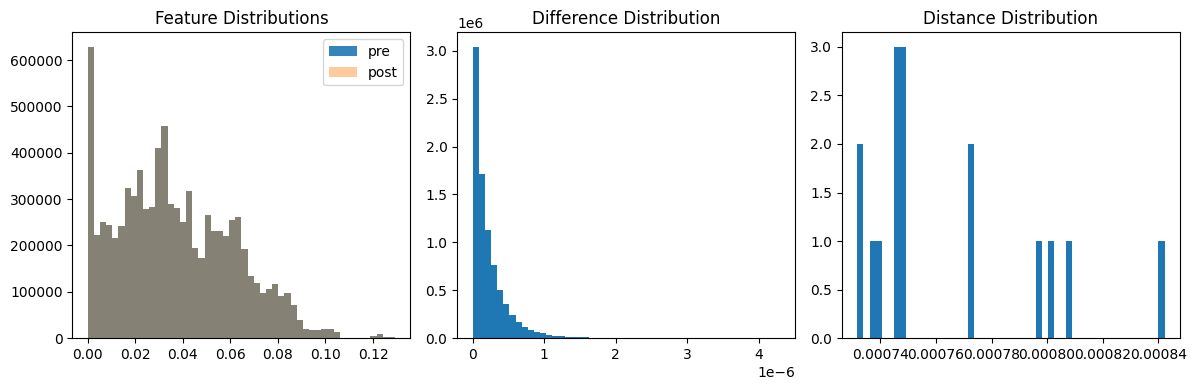

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def analyze_distance_maps(pre, post, name=""):
    # Convert to tensors if not already
    pre = torch.tensor(pre)
    post = torch.tensor(post)
    
    # 1. Check distribution of differences
    diff = (pre - post).abs()
    print(f"\n{name} Analysis:")
    print(f"Difference stats - mean: {diff.mean():.6f}, std: {diff.std():.6f}")
    
    # 2. Check pairwise distances
    pre_flat = pre.view(pre.size(0), -1)
    post_flat = post.view(post.size(0), -1)
    distances = F.pairwise_distance(pre_flat, post_flat, p=2)
    print(f"Distance stats - mean: {distances.mean():.6f}, min: {distances.min():.6f}, max: {distances.max():.6f}")
    
    # 3. Plot histograms
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.hist(pre.flatten().numpy(), bins=50, alpha=0.9, label='pre')
    plt.hist(post.flatten().numpy(), bins=50, alpha=0.4, label='post')
    plt.title('Feature Distributions')
    plt.legend()
    
    plt.subplot(132)
    plt.hist(diff.flatten().numpy(), bins=50)
    plt.title('Difference Distribution')
    
    plt.subplot(133)
    plt.hist(distances.numpy(), bins=50)
    plt.title('Distance Distribution')
    
    plt.tight_layout()
    plt.show()

# Analyze both train and validation
analyze_distance_maps(pre_train, post_train, "Training")
analyze_distance_maps(pre_val, post_val, "Validation")